# SeaFlow data (regridded)

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafile = 'data/Zinser_SizeDist_regrid-20-12.nc'

data_seaflow = {}
with nc4.Dataset(datafile) as nc:
    for var in nc.variables:
        data_seaflow[var] = nc.variables[var][:]

### experimental part: shift down size classes

In [2]:
delta_v = 1.0/data_seaflow['delta_v_inv']
v = data_seaflow['v_min'] * 2**(np.arange(data_seaflow['m'])*delta_v) 

num_remove = 6

data_seaflow['v_min'] = v[num_remove]
w_obs = np.zeros_like(data_seaflow['w_obs'])
w_obs[:-num_remove] = data_seaflow['w_obs'][num_remove:,:]
data_seaflow['w_obs'] = w_obs

In [3]:
v_min = data_seaflow['v_min']
delta_v = 1.0/data_seaflow['delta_v_inv']
v = v_min * 2**(np.arange(data_seaflow['m'])*delta_v) 

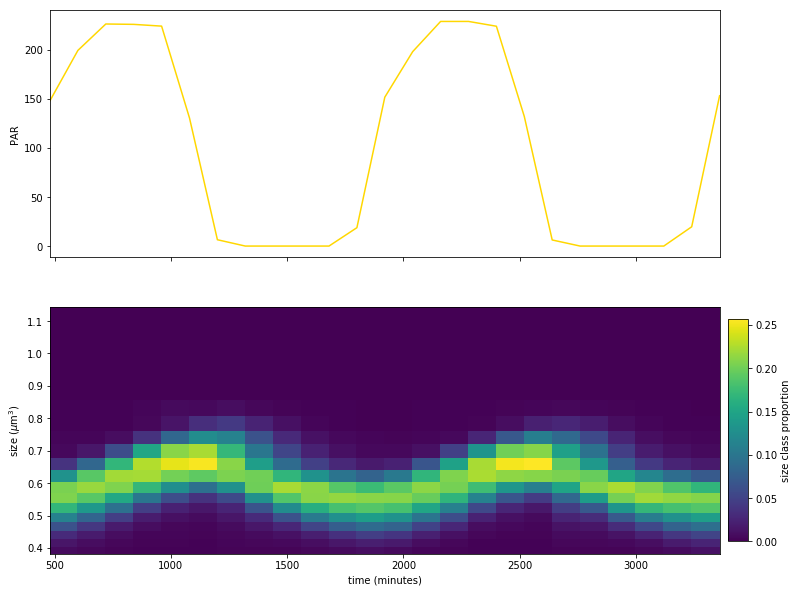

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

fig,axs = plt.subplots(nrows=2, sharex=True, figsize=(12,10))

ax = axs[0]
ax.plot(data_seaflow['time'], data_seaflow['PAR'], color='gold')
ax.set(ylabel='PAR')

ax = axs[1]
pc = ax.pcolormesh(data_seaflow['time'],v,data_seaflow['w_obs'])
ax.set(ylabel='size ($\mu$m$^3$)', xlabel='time (minutes)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [5]:
# prepare data for Stan model

dt = 20 # in units of minutes

data = {'dt':dt}
for k in ('m','v_min','delta_v_inv'):
    data[k] = data_seaflow[k]

data['obs'] = data_seaflow['w_obs']
data['t_obs'] = data_seaflow['time']
data['E'] = data_seaflow['PAR']
# use first measurements as initial conditions
data['w_ini'] = data_seaflow['w_obs'][:,0]

# limit the data

limit_days = 2
stride_t_obs = 1 # keep everything

if limit_days > 0:
    limit_minutes = limit_days*1440
    
    ind_obs = data['t_obs'] < limit_minutes
    data['t_obs'] = data['t_obs'][ind_obs]
    data['obs'] = data['obs'][:,ind_obs]

    data['nt'] = int(limit_minutes//data['dt'])
    
if stride_t_obs > 0:
    data['t_obs'] = data['t_obs'][::stride_t_obs]
    data['obs'] = data['obs'][:,::stride_t_obs]

data['nt_obs'] = data['obs'].shape[1]
    
# finally, add light data
t = np.arange(data['nt'])*data['dt']
data['E'] = np.interp(t, xp=data_seaflow['time'], fp=data_seaflow['PAR'])

print(data['t_obs'])

[ 480  600  720  840  960 1080 1200 1320 1440 1560 1680 1800 1920 2040
 2160 2280 2400 2520 2640 2760]


### load various models and modify prior for some of them

In [6]:
import re

stan_files = {
    'freedelta':'stancode/matrixmodel_freedelta_normparam_trackgrowth.stan',
    'resp':'stancode/matrixmodel_freedelta_resp_normparam_trackgrowth.stan',
    'respi_gammai':'stancode/matrixmodel_freedelta_respi_gammai_normparam_trackgrowth.stan',
}
desc = {
    'freedelta':'basic model with "free" deltas',
    'resp':'model with respiration and "free" deltas',
    'respi_gammai':'model with size-dep. respiration, size-dep. growth and "free" deltas',
}

stan_codes = {}
for name in stan_files:
    with open(stan_files[name]) as f:
        stan_codes[name] = f.read()

for name in ('resp','respi_gammai'):
    name_new = name+'_enforceresp'
    code_split = stan_codes[name].split('\n')
    code_split_new = []
    for line in code_split:
        m = re.match('^( *respiration *\~)',line)
        if m:
            code_split_new.append(m.groups(0)[0]+' uniform(0.1,10.0); // enforce respiration')
        else:
            code_split_new.append(line)
    stan_codes[name_new] = '\n'.join(code_split_new)
    desc[name_new] = desc[name] + ' with enforced respiration'

In [7]:
import pystan

models = {name:pystan.StanModel(model_code=stan_codes[name], model_name=name, obfuscate_model_name=False) for name in stan_codes}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL freedelta NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL resp NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL respi_gammai NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL resp_enforceresp NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL respi_gammai_enforceresp NOW.


In [10]:
mcmcs = {}
for name in models:
    mcmcs[name] = models[name].sampling(data=data, iter=2000)
    print('\n'.join(x for x in mcmcs[name].__str__().split('\n') if 'mod_obspos' not in x))

Inference for Stan model: freedelta.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            2.23    0.03   0.94   0.68   1.52   2.18   2.86   4.23    724    1.0
delta_sigma         0.99    0.03   0.73   0.11   0.44   0.82   1.34   2.82    555   1.01
delta_max[1]        1.27    0.05   1.01   0.06   0.49   0.99   1.83   3.76    479   1.01
delta_max[2]        2.17    0.04   1.34   0.26   1.16   1.95    2.9   5.42   1106    1.0
delta_max[3]        2.38    0.04   1.46   0.37   1.33   2.13   3.15   5.89   1209    1.0
delta_max[4]        2.38    0.04    1.5   0.38   1.28   2.14   3.18    6.1   1347    1.0
delta_max[5]        2.39    0.04   1.51   0.36   1.28   2.12   3.12   6.05   1239    1.0
delta_max[6]        2.36    0.04   1.46    0.4   1.29    2.1   3.11   5.92   1269    1.0
delta_max[7]        2.34    0.04   1.44    0

Inference for Stan model: resp.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            1.99    0.03   0.93   0.35   1.32   1.93    2.6   3.92    735    1.0
delta_sigma         0.95    0.03   0.71   0.11   0.42   0.78    1.3   2.76    622    1.0
delta_max[1]        1.05    0.03   0.86   0.05   0.37   0.82    1.5   3.23    777   1.01
delta_max[2]        1.92    0.04   1.26   0.19    1.0   1.72   2.56   4.92   1181    1.0
delta_max[3]        2.07    0.04   1.41   0.21   1.06   1.79   2.74   5.63   1092    1.0
delta_max[4]        2.11    0.04   1.44   0.21   1.08   1.82    2.8   5.78   1082    1.0
delta_max[5]         2.1    0.04   1.44   0.19   1.07   1.84   2.79   5.85   1167    1.0
delta_max[6]         2.1    0.04   1.42   0.21   1.09   1.85   2.81   5.76   1167    1.0
delta_max[7]        2.08    0.04   1.44   0.19   

Inference for Stan model: respi_gammai.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            2.05    0.03   0.93   0.44   1.36    2.0   2.73   3.97    774    1.0
delta_sigma          0.9    0.03    0.7   0.11   0.37   0.73   1.24    2.6    672    1.0
delta_max[1]        1.16    0.05   0.91   0.07   0.44   0.91   1.68    3.3    335    1.0
delta_max[2]        1.95    0.04   1.26   0.18   1.01   1.74   2.69   4.95    878    1.0
delta_max[3]        2.17    0.04   1.36   0.27   1.18   1.95   2.88   5.37   1202    1.0
delta_max[4]        2.14    0.04   1.35   0.26   1.18   1.92   2.85   5.38   1144    1.0
delta_max[5]        2.14    0.04   1.38   0.23   1.15   1.93   2.84   5.44   1123    1.0
delta_max[6]        2.16    0.04   1.42   0.28   1.13   1.91   2.84   5.84   1244    1.0
delta_max[7]        2.18    0.04   1.41  

Inference for Stan model: resp_enforceresp.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            1.84    0.92   1.55   0.02   0.32   1.58   2.98   5.02      3   2.05
delta_sigma         2.18    1.46   2.33 8.8e-4    0.2   1.46   3.22   7.97      3   2.26
delta_max[1]        0.27    0.24   0.52 2.1e-3   0.02   0.08   0.21   1.86      5   1.36
delta_max[2]        0.49    0.45   0.96 4.0e-3   0.04   0.12   0.38   3.52      5   1.36
delta_max[3]         0.8    0.74   1.55 9.0e-3   0.06    0.2   0.64   5.54      4   1.39
delta_max[4]        1.89    1.74    3.1 7.0e-3   0.13   0.48   1.86  11.33      3   1.68
delta_max[5]        3.27    2.93   4.78 7.6e-3   0.17   1.14   3.93  16.69      3   2.01
delta_max[6]        3.92    3.06   5.14   0.02   0.28   1.84   5.17  18.14      3   1.88
delta_max[7]        4.21    2.99   5.

Inference for Stan model: respi_gammai_enforceresp.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            0.33    0.11    0.5   0.02   0.06   0.14    0.3   1.85     20   1.19
delta_sigma         0.24     0.1   0.45 3.6e-3   0.02   0.06   0.18   1.66     22   1.18
delta_max[1]         0.1  8.5e-3   0.09 3.3e-3   0.04   0.07   0.14   0.35    120   1.04
delta_max[2]        0.13    0.01   0.13 6.1e-3   0.05   0.09   0.18   0.47    104   1.03
delta_max[3]         0.2    0.04   0.26   0.01   0.05   0.12   0.23   0.96     50   1.08
delta_max[4]         0.3    0.08   0.49   0.01   0.07   0.14    0.3   1.78     43   1.08
delta_max[5]        0.38    0.13   0.68   0.01   0.07   0.14   0.33   2.28     29   1.13
delta_max[6]        0.41    0.15   0.77   0.01   0.06   0.14   0.33   2.86     27   1.14
delta_max[7]        0.44    0

## Plot the results

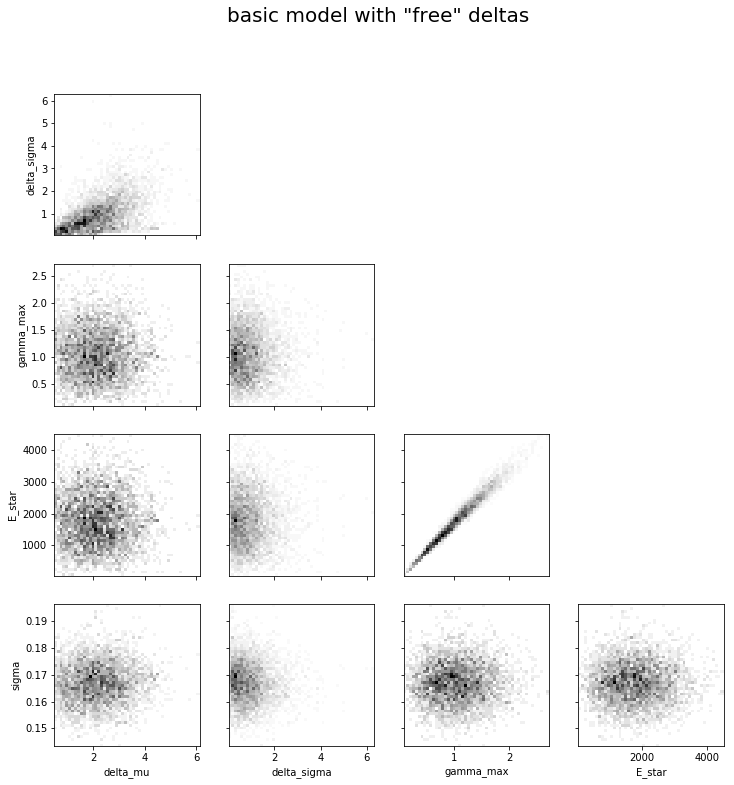

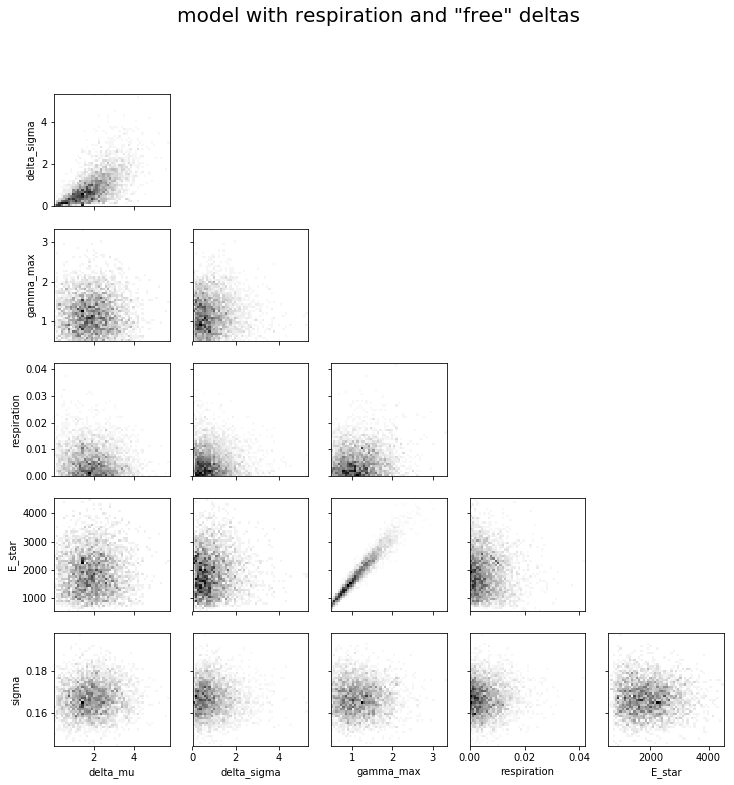

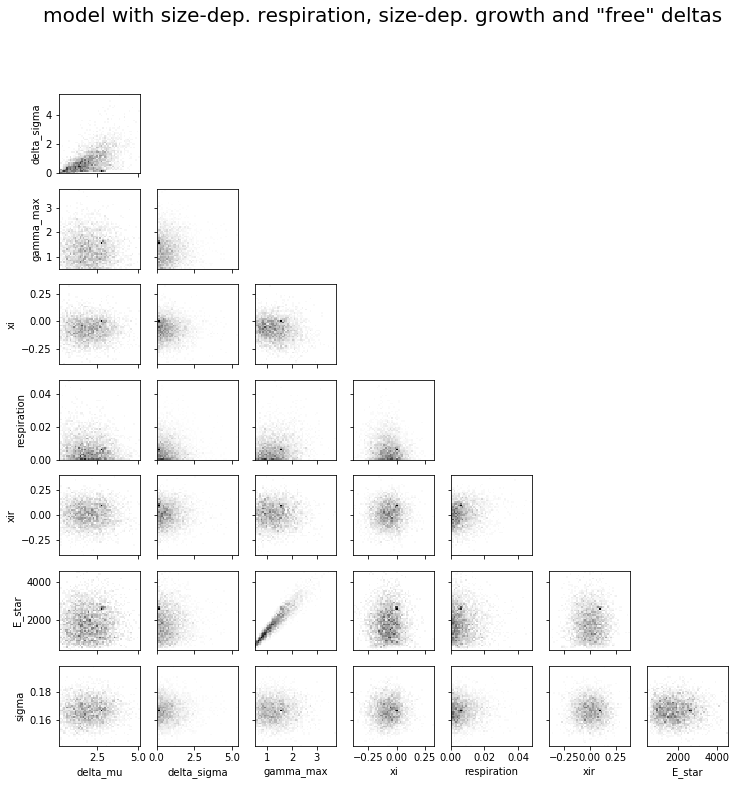

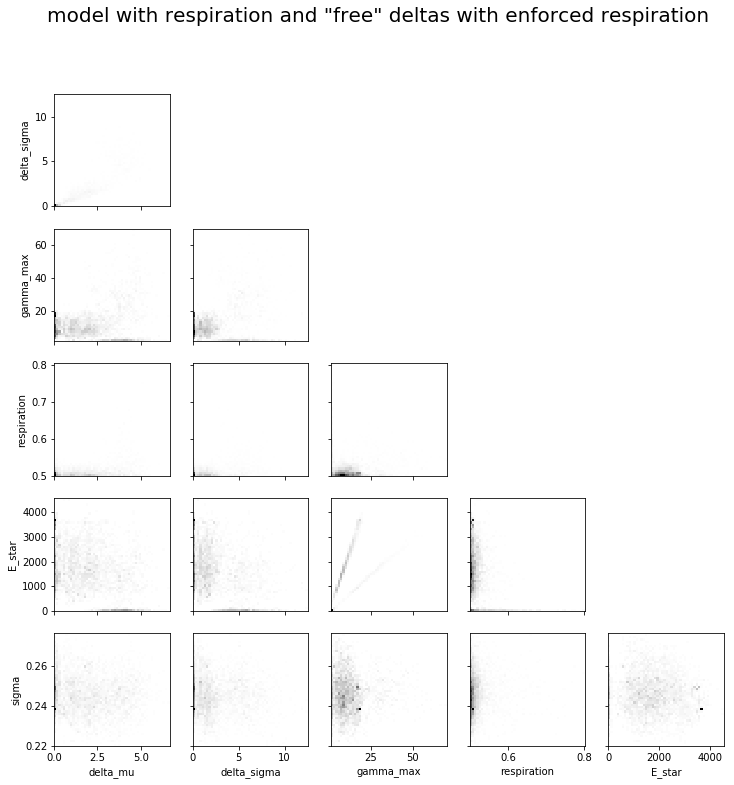

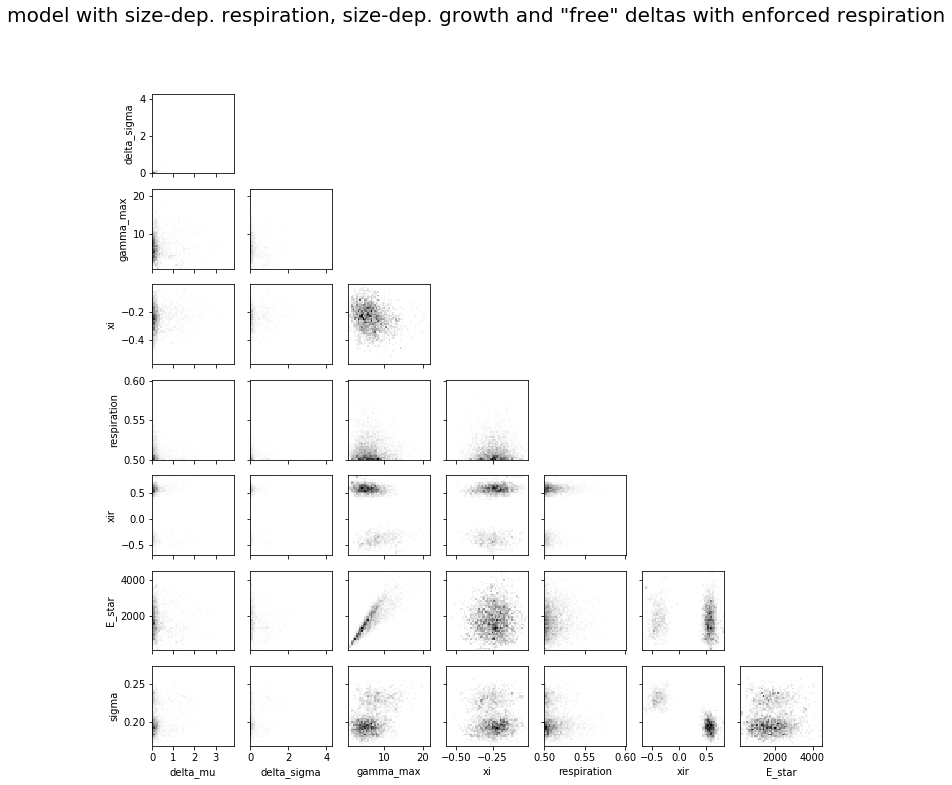

In [11]:
for name,mcmc in mcmcs.items():
    paramnames = [v for v in mcmc.flatnames if not v.startswith('mod_obspos') and not v.startswith('delta_max')]
    num_params = len(paramnames)

    fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
    fig.suptitle(desc[name], size=20)
    for ax in axs.flat:
        ax.set_visible(False)
    for irow in range(1,num_params):
        for icol in range(irow):
            ax = axs[irow-1,icol]
            ax.set_visible(True)
            xname = paramnames[icol]
            yname = paramnames[irow]
            ax.hist2d(mcmc[xname],mcmc[yname],bins=50,cmap=mpl.cm.gray_r)
            if icol == 0:
                ax.set_ylabel(yname)
            if irow == num_params-1:
                ax.set_xlabel(xname)

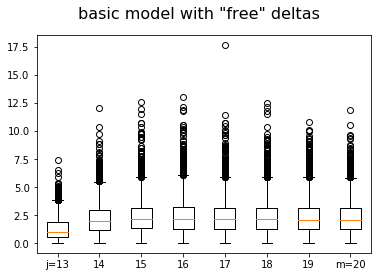

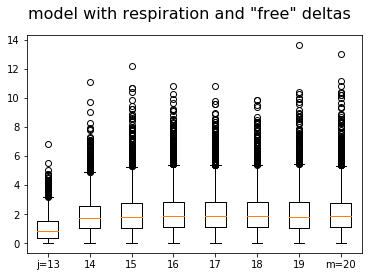

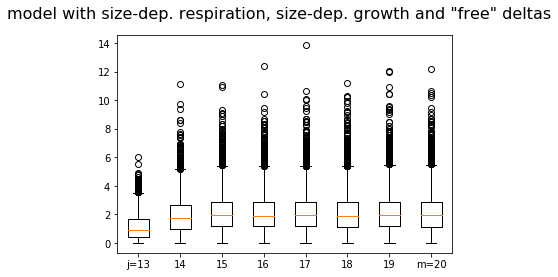

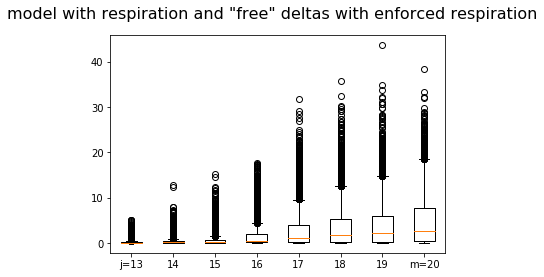

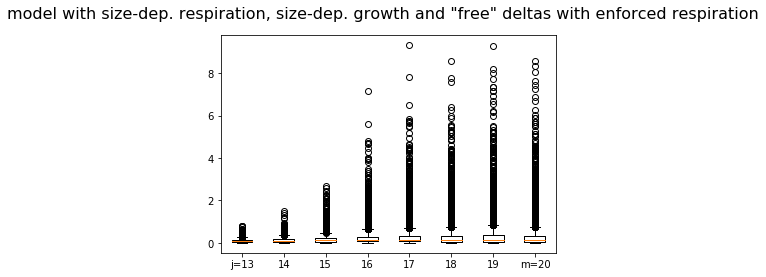

In [13]:
for name,mcmc in mcmcs.items():
    j = data_seaflow['delta_v_inv'] + 1
    m = data_seaflow['m']
    
    fig, ax = plt.subplots()
    fig.suptitle(desc[name], size=16)
    ax.boxplot(mcmc['delta_max'])
    xlabels = [str(x) for x in range(j,m+1)]
    xlabels[0] = 'j='+xlabels[0]
    xlabels[-1] = 'm='+xlabels[-1]
    ax.set_xticklabels(xlabels)
    None

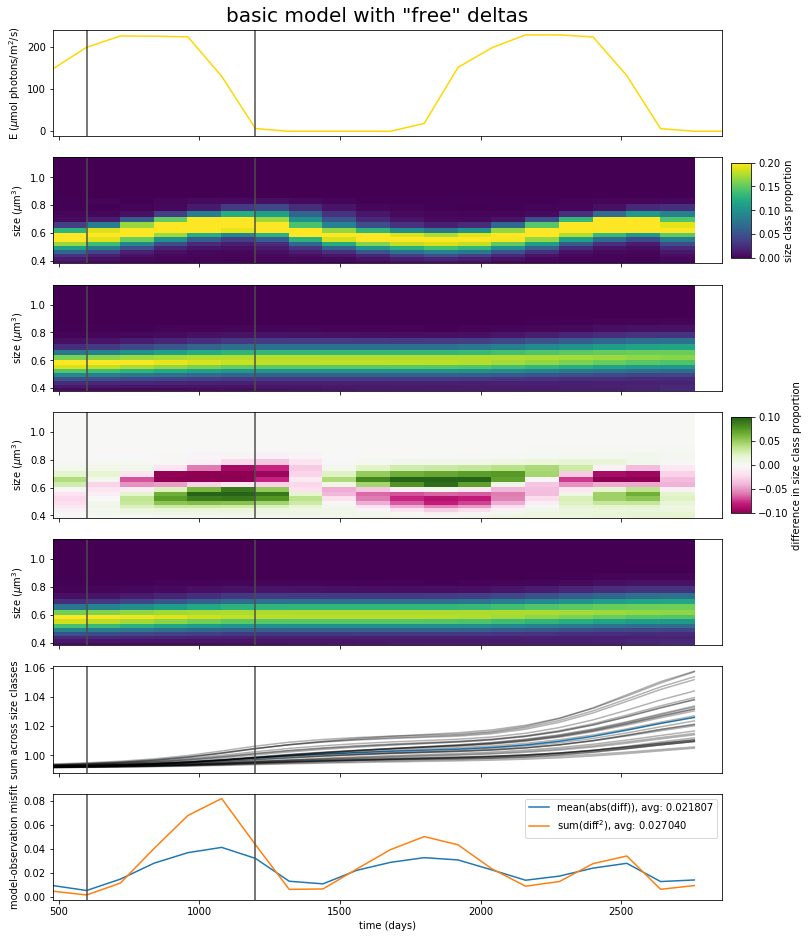

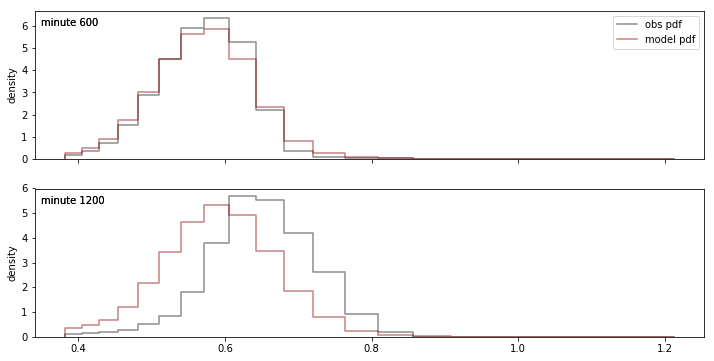

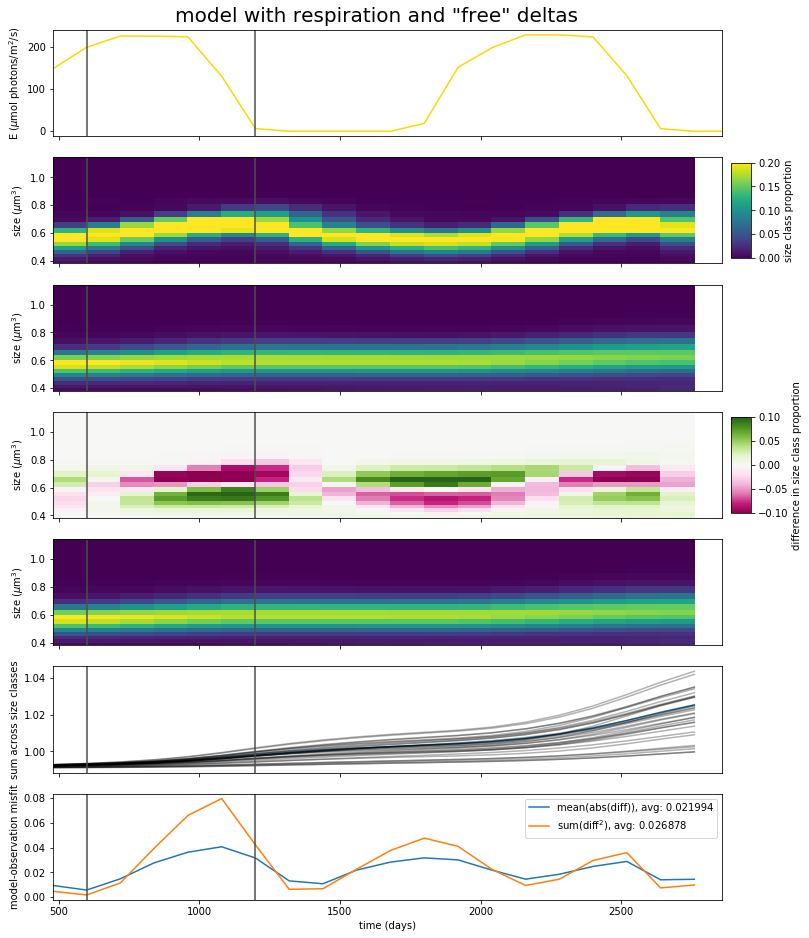

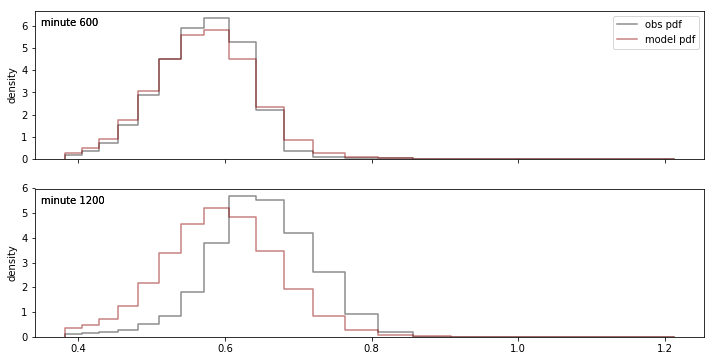

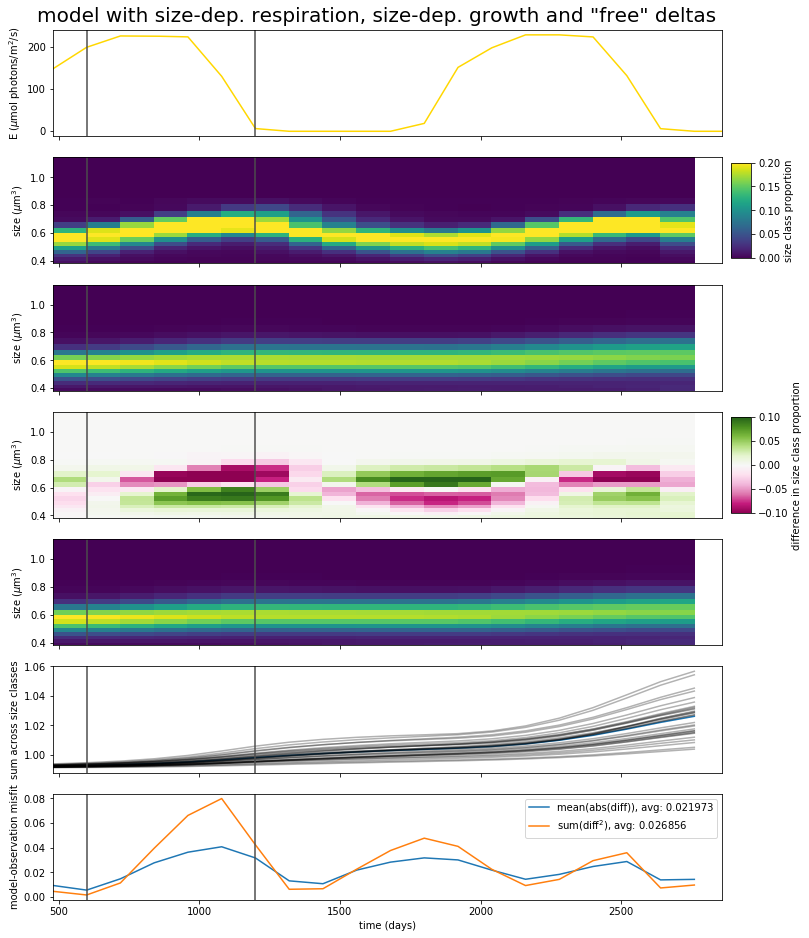

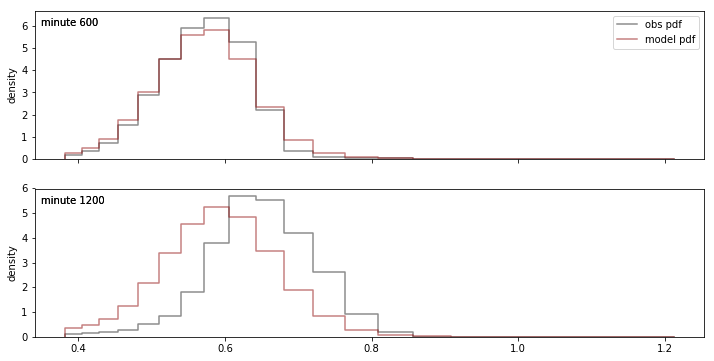

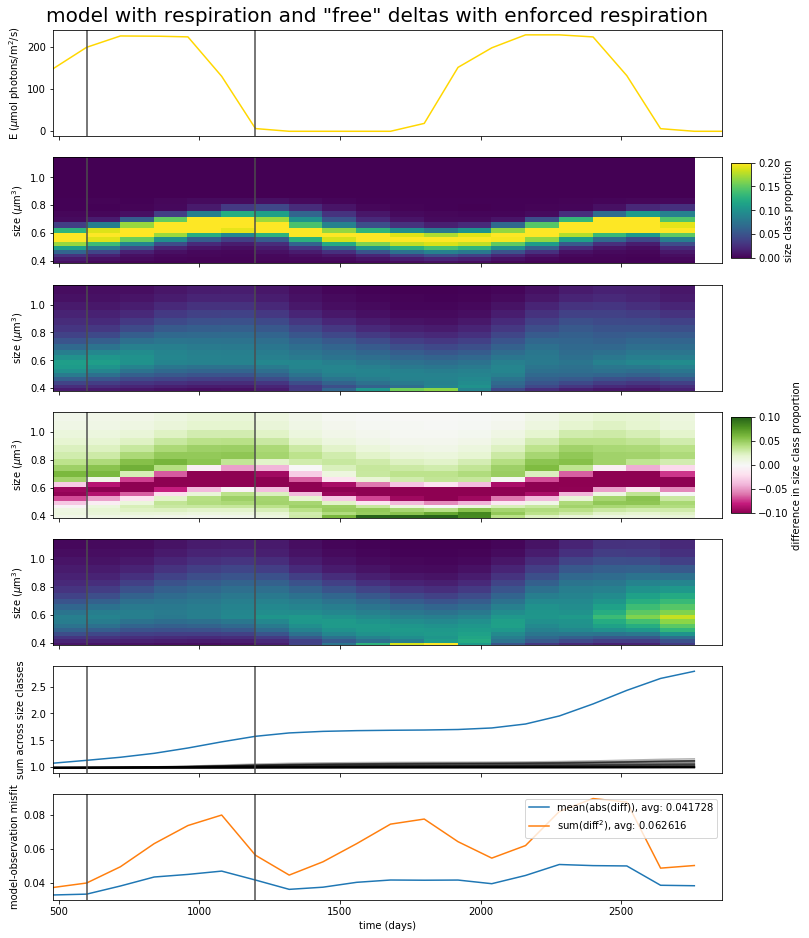

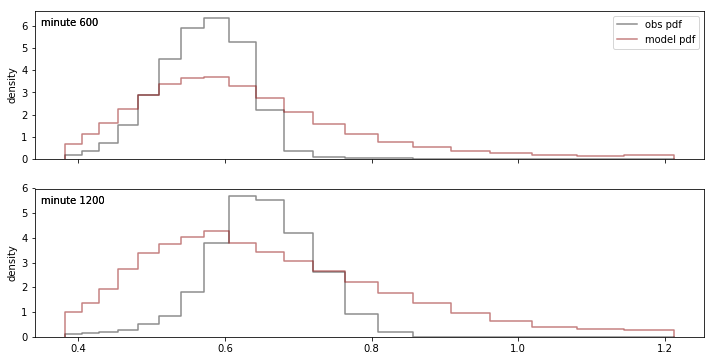

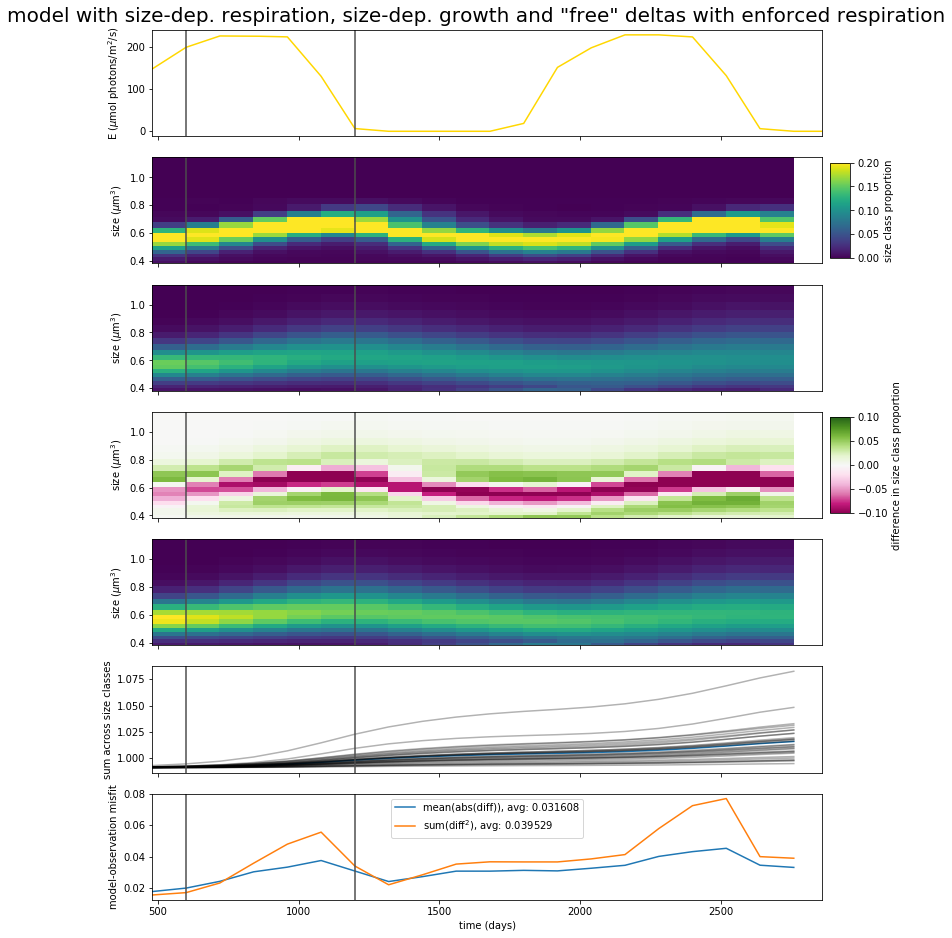

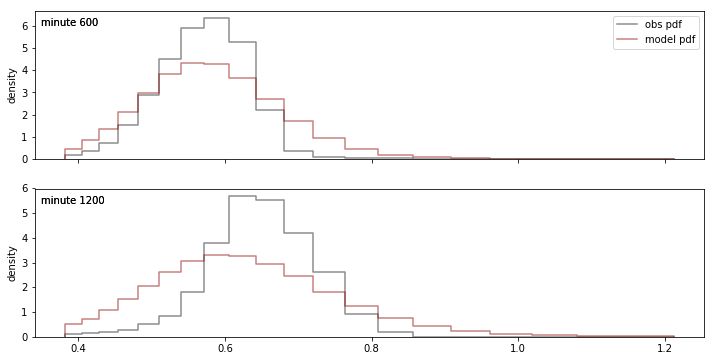

In [17]:
colors = {'model':'darkred', 'obs':'0.1'}

t = data['dt']*np.arange(data['nt'])
slice_indices = [1,6]
v_ext = data['v_min'] * 2**(np.arange(data['m']+1)*delta_v) 
v_width = v_ext[1:] - v_ext[:-1]

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for name,mcmc in mcmcs.items():
    res = {'model':np.mean(mcmc['mod_obspos'], axis=0), 'obs':data['obs']}
    res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
    diff = res_sum1-res['obs']

    fig,axs = plt.subplots(7,1,sharex=True,figsize=(12,16))
    fig.suptitle(desc[name], size=20, y=0.9)
    
    ax = axs[0]
    ax.plot(t, data['E'], color='gold')
    ax.set(xlim=(data['t_obs'][0],t[-1]), ylabel='E ($\mu$mol photons/m$^{2}$/s)')

    ax = axs[1]
    pc = ax.pcolormesh(data['t_obs'],v,res['obs'],norm=norm)
    ax.set(ylabel='size ($\mu$m$^3$)')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

    ax = axs[2]
    ax.set(ylabel='size ($\mu$m$^3$)')
    pc = ax.pcolormesh(data['t_obs'],v,res_sum1,norm=norm)

    ax = axs[3]
    pc = ax.pcolormesh(data['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
    ax.set(ylabel='size ($\mu$m$^3$)')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')

    ax = axs[4]
    ax.set(ylabel='size ($\mu$m$^3$)')
    pc = ax.pcolormesh(data['t_obs'],v,res['model'])

    ax = axs[5]
    ax.plot(data['t_obs'], np.sum(res['model'],axis=0))
    ax.plot(data['t_obs'], np.sum(mcmc['mod_obspos'][:30,...], axis=1).T, color='k', alpha=0.3)
    ax.set(ylabel='sum across size classes')

    ax = axs[6]
    prop = np.mean(np.abs(diff),axis=0)
    ax.plot(data['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
    prop = np.sum(diff**2,axis=0)
    ax.plot(data['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
    ax.set(xlabel='time (days)', ylabel='model-observation misfit')
    ax.legend()

    for ax in axs.flat:
        for i in slice_indices:
            ax.axvline(data['t_obs'][i], color='.3')

    # plot slices

    plotdata_y = np.zeros(2*(data['m']+1))

    fig,axs = plt.subplots(nrows=len(slice_indices), sharex=True, figsize=(12,len(slice_indices)*3))
    for i,ax in zip(slice_indices,axs.flat):
        for name in ('obs','model'):
            color = colors[name]
            cdata = res[name][:,i]
            plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
            ax.plot(np.repeat(v_ext,2), plotdata_y, color=color, alpha=0.5, label='{} pdf'.format(name))
            ax.text(0.01, 0.95, 'minute {}'.format(data['t_obs'][i]), transform=ax.transAxes, va='top', ha='left')
            ax.set_ylabel('density')
            ax.set_ylim(bottom=0.0)
    axs[0].legend()
    None

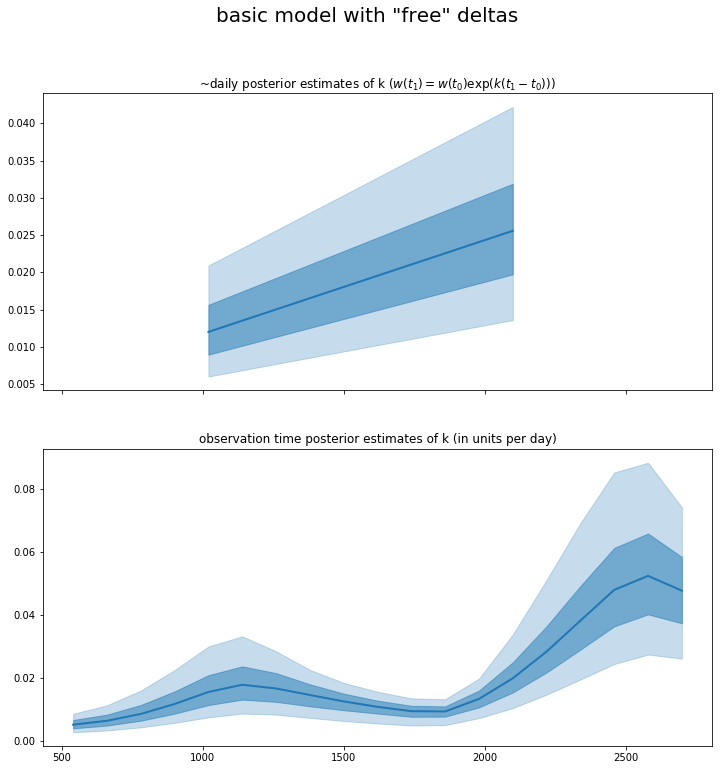

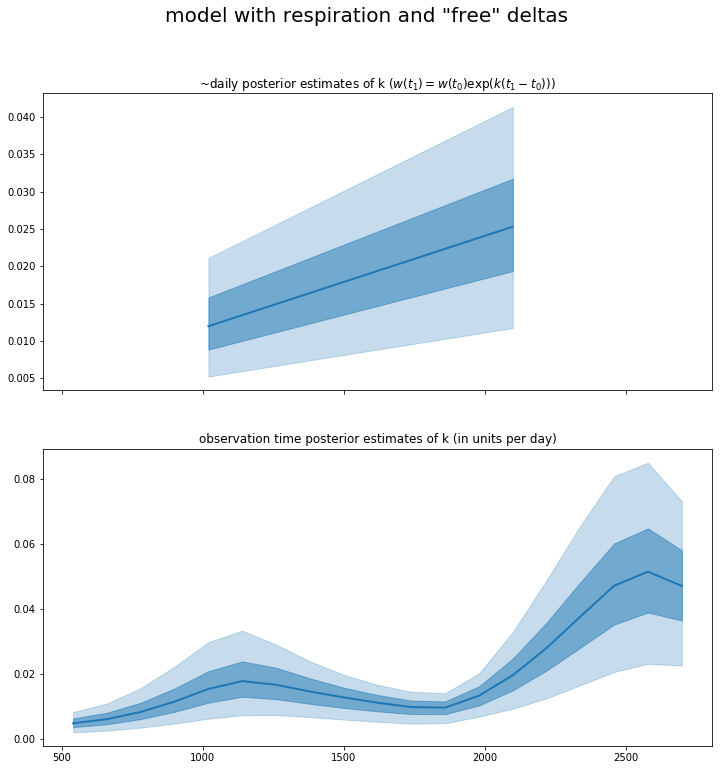

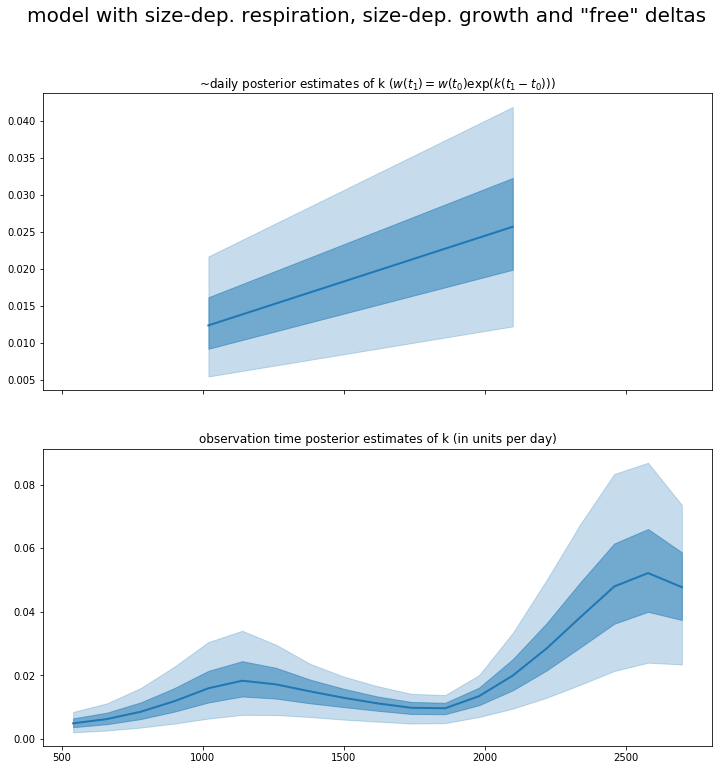

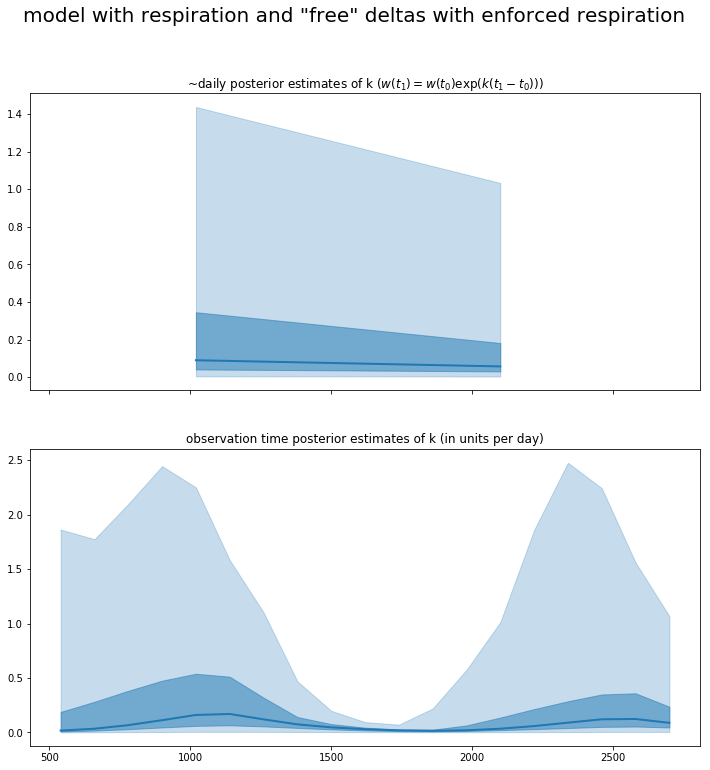

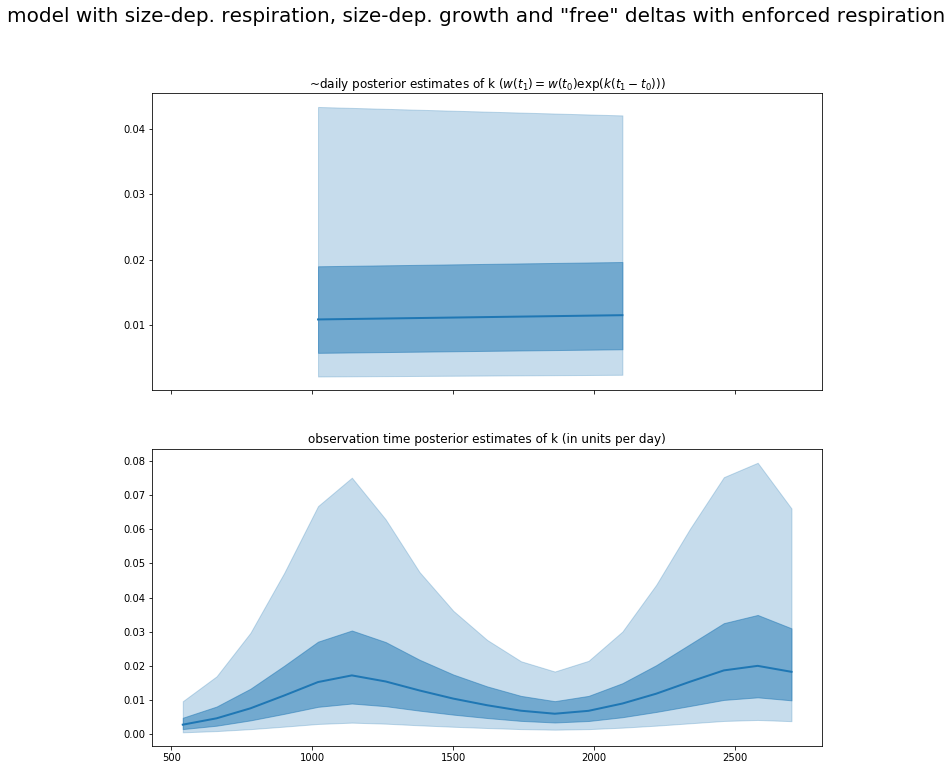

In [25]:
dt_obs = data['t_obs'][1]-data['t_obs'][0]

ndt = {'day':9, 'dt_obs':1}

for name,mcmc in mcmcs.items():
    sum_pop = np.sum(mcmc['mod_obspos'], axis=1)

    fig,axs = plt.subplots(nrows=2,sharex=True,figsize=(12,12))
    fig.suptitle(desc[name], size=20)
    for ax,key in zip(axs,ndt):
        t = data['t_obs'][::ndt[key]]
        tmp = sum_pop[:,::ndt[key]]
        tmp = tmp[:,1:] / tmp[:,:-1]
        k = np.log(tmp)/((t[1:]-t[:-1])/1440.0)

        q = np.percentile(k, q=(5,25,50,75,95), axis=0)

        t_mid = 0.5*(t[1:]+t[:-1])

        ax.fill_between(t_mid, q[0,:], q[-1,:], color='C0', alpha=0.25)
        ax.fill_between(t_mid, q[1,:], q[-2,:], color='C0', alpha=0.5)
        ax.plot(t_mid, q[2,:], color='C0', lw=2)
    axs[0].set_title('~daily posterior estimates of k ($w(t_1) = w(t_0)\exp(k (t_1-t_0))$)')
    axs[1].set_title('observation time posterior estimates of k (in units per day)')
    None

In [20]:
print(ndt)

{'day': 11, 'dt_obs': 1}
